In [1]:
from src import data_loader, features, model, evaluate, utils
import yaml

import pandas as pd
import datetime as dt

from sklearn.model_selection import train_test_split

In [2]:
# Loading dataset
config = yaml.safe_load(open("config/config.yaml"))

df = data_loader.load_data(config['data']['raw_path'])
df = data_loader.clean_data(df)

# Pre-Processing

In [3]:
# Extracting datetime features
features.featExtract(df, Date=True)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,12
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,19
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,26
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,5


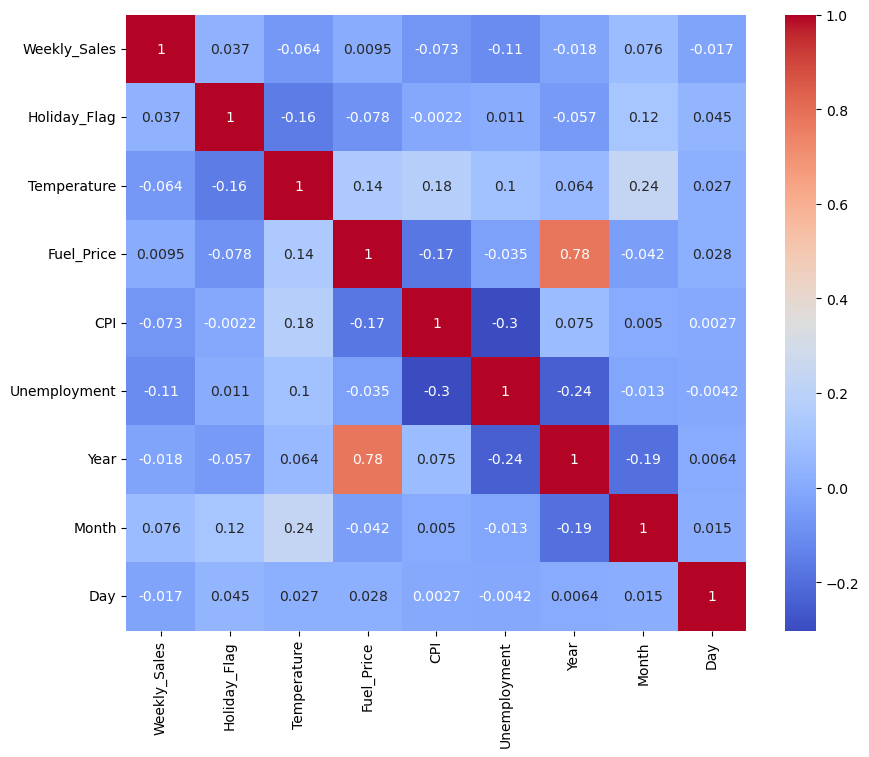

In [4]:
selected_columns = ['Weekly_Sales','Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day']
data_selected = df[selected_columns]

utils.heatmap(data_selected)

In [5]:
# Target variables selection
X = df.iloc[:, [0,3,4,5,6,7,8,9,10]]
y = df['Weekly_Sales']
print(X.size, y.size)

57915 6435


In [6]:
# Splitting data for Training
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 42)

# Prediction Config - Next 12 Weeks

In [7]:
# Assuming last date in the dataset to be last row of given data
last_date = pd.to_datetime(df['Date'].iloc[-1])

In [8]:
# Creating 12 future dates
future_dates = [last_date + dt.timedelta(weeks=i) for i in range(1, 13)]

In [9]:
# Creating a DataFrame for future predictions
future_data = pd.DataFrame({
    'Date': future_dates,
    'Store': [1] * 12,
    'Holiday_Flag': [0] * 12,
    'Temperature': [df['Temperature'].mean()] * 12,
    'Fuel_Price': [df['Fuel_Price'].mean()] * 12,
    'CPI': [df['CPI'].mean()] * 12,
    'Unemployment': [df['Unemployment'].mean()] * 12,
})

In [10]:
# Extracting DateTime
features.featExtract(future_data, Date=True)
future_data

,Date,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
0,2012-11-02,1,0,60.663782,3.358607,171.578394,7.999151,2012,11,2
1,2012-11-09,1,0,60.663782,3.358607,171.578394,7.999151,2012,11,9
2,2012-11-16,1,0,60.663782,3.358607,171.578394,7.999151,2012,11,16
3,2012-11-23,1,0,60.663782,3.358607,171.578394,7.999151,2012,11,23
4,2012-11-30,1,0,60.663782,3.358607,171.578394,7.999151,2012,11,30
5,2012-12-07,1,0,60.663782,3.358607,171.578394,7.999151,2012,12,7
6,2012-12-14,1,0,60.663782,3.358607,171.578394,7.999151,2012,12,14
7,2012-12-21,1,0,60.663782,3.358607,171.578394,7.999151,2012,12,21
8,2012-12-28,1,0,60.663782,3.358607,171.578394,7.999151,2012,12,28
9,2013-01-04,1,0,60.663782,3.358607,171.578394,7.999151,2013,1,4


In [11]:
# Target variable for Prediction
X_future = future_data[['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day']]

# Linear Regression

### Model

In [12]:
# Linear Regression Model
model_type = config['models']['linear_regressor']
model_obj = model.build_model(model_type['type'], model_type['params'])
model.train_model(model_obj, X_train, y_train)

LinearRegression()

In [13]:
evaluate.evaluate(model_obj, X_test, y_test)

LinearRegression()

r2: 0.1554859026152028
MSE: 272064071370.04953
RMSE: 521597.61442135595
MAE: 432598.3045496046
RMAE: 0.6218824163441073


In [14]:
evaluate.pred_values(model_obj, X_test, y_test)

      Actual Value  Predicted Value
0       1138800.32     1.160664e+06
1       1304850.67     1.090997e+06
2       1769296.25     1.299941e+06
3       1077640.13     1.196358e+06
4        428851.99     6.946352e+05
...            ...              ...
1282    1492060.89     1.208209e+06
1283     801098.43     6.170610e+05
1284     890689.51     6.700118e+05
1285    2066187.72     1.253090e+06
1286     816138.33     1.273923e+06

[1287 rows x 2 columns]


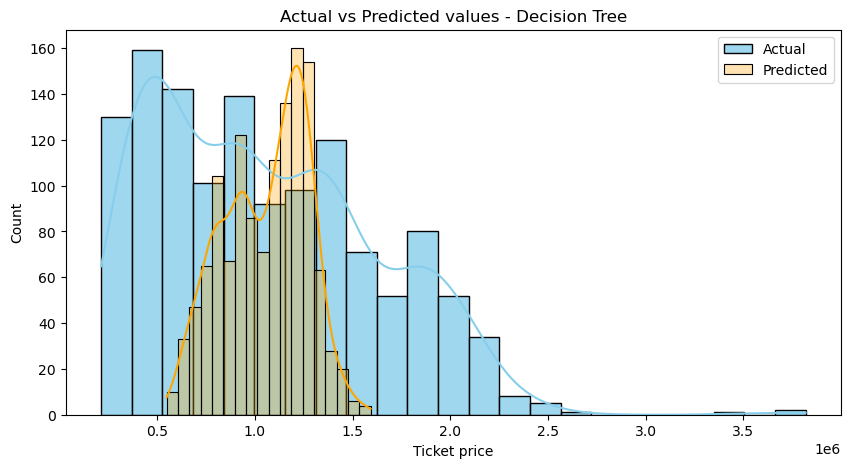

In [15]:
evaluate.pred_plot(model_obj, X_test, y_test)

### Prediction - Future weeks

In [16]:
print(X_test.size, X_future.size)
print(y_test.size)

11583 108
1287


In [17]:
lr_pred  = evaluate.pred(model_obj, X_future, y_test)

# Random Forest 

In [18]:
# Random Forest Regressor Model
model_type = config['models']['random_forest']
model_obj = model.build_model(model_type['type'], model_type['params'])
model.train_model(model_obj, X_train, y_train)

rfr = model_obj

In [19]:
evaluate.evaluate(model_obj, X_test, y_test)

RandomForestRegressor(max_depth=10)

r2: 0.9503620992226699
MSE: 15991076314.253223
RMSE: 126455.82752191859
MAE: 69551.68151156958
RMAE: 0.06335737090754642


In [20]:
evaluate.pred_values(model_obj, X_test, y_test)

      Actual Value  Predicted Value
0       1138800.32     1.183783e+06
1       1304850.67     1.284125e+06
2       1769296.25     1.761980e+06
3       1077640.13     1.038727e+06
4        428851.99     4.567631e+05
...            ...              ...
1282    1492060.89     1.407289e+06
1283     801098.43     7.666175e+05
1284     890689.51     7.539774e+05
1285    2066187.72     1.983324e+06
1286     816138.33     8.186041e+05

[1287 rows x 2 columns]


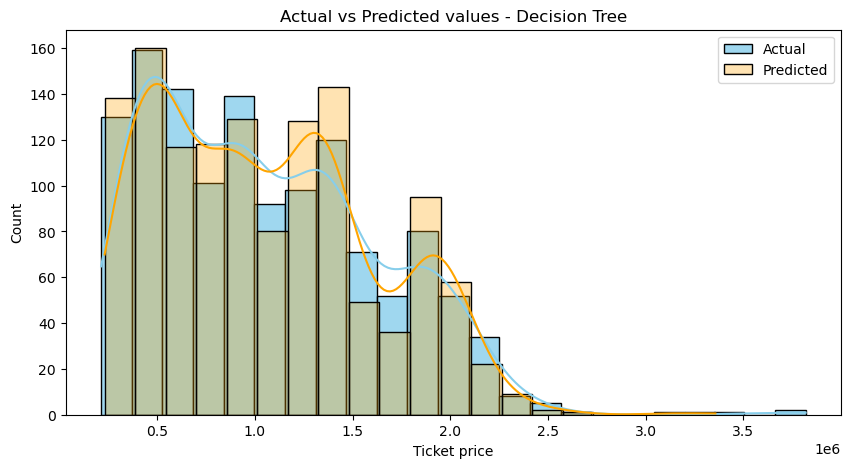

In [21]:
evaluate.pred_plot(model_obj, X_test, y_test)

### Prediction - Future weeks

In [22]:
rfr_pred  = evaluate.pred(model_obj, X_future, y_test)

# XGBoost

In [23]:
# XGBoost Regressor Model
model_type = config['models']['XGBoost']
model_obj = model.build_model(model_type['type'], model_type['params'])
model.train_model(model_obj, X_train, y_train)

xgb = model_obj

In [24]:
evaluate.evaluate(model_obj, X_test, y_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

r2: 0.9710900150517905
MSE: 9313483614.558208
RMSE: 96506.39157360619
MAE: 50361.99360771173
RMAE: 0.0469713187268987


In [25]:
evaluate.pred_values(model_obj, X_test, y_test)

      Actual Value  Predicted Value
0       1138800.32     1.141322e+06
1       1304850.67     1.358780e+06
2       1769296.25     1.792351e+06
3       1077640.13     1.013520e+06
4        428851.99     4.228841e+05
...            ...              ...
1282    1492060.89     1.476250e+06
1283     801098.43     7.715268e+05
1284     890689.51     7.477859e+05
1285    2066187.72     2.014511e+06
1286     816138.33     7.907743e+05

[1287 rows x 2 columns]


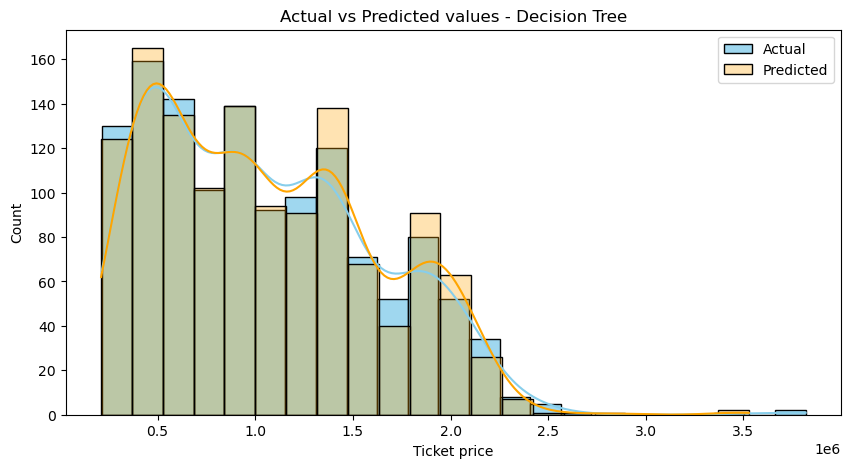

In [26]:
evaluate.pred_plot(model_obj, X_test, y_test)

### Prediction - Future weeks

In [27]:
xgb_pred  = evaluate.pred(model_obj, X_future, y_test)

# Prediction Plot - Next 12 weeks

In [28]:
# Adding Predicted values to  future_data
future_data['Predicted_Sales_LinearReg'] = lr_pred
future_data['Predicted_Sales_RandForest'] = rfr_pred
future_data['Predicted_Sales_xgb'] = xgb_pred

In [29]:
future_data.iloc[:, [0,10,11,12]]

,Date,Predicted_Sales_LinearReg,Predicted_Sales_RandForest,Predicted_Sales_xgb
0,2012-11-02,1.441042e+06,1.897927e+06,2000489.00
1,2012-11-09,1.429659e+06,1.899214e+06,2059768.00
2,2012-11-16,1.418275e+06,1.939481e+06,2052784.25
3,2012-11-23,1.406892e+06,2.477534e+06,2972150.00
4,2012-11-30,1.395509e+06,1.886615e+06,2258325.00
5,2012-12-07,1.447459e+06,2.237203e+06,2406348.50
6,2012-12-14,1.436076e+06,2.334556e+06,2533455.25
7,2012-12-21,1.424693e+06,2.602500e+06,3365362.75
8,2012-12-28,1.413310e+06,2.718203e+06,2633283.00
9,2013-01-04,1.269377e+06,1.733574e+06,1784221.75


In [30]:
# Melting data for easier plotting
melted_data = future_data.melt(id_vars='Date', 
                                 value_vars=['Predicted_Sales_LinearReg', 'Predicted_Sales_RandForest', 'Predicted_Sales_xgb'],
                                 var_name='Model', 
                                 value_name='Predicted_Sales')

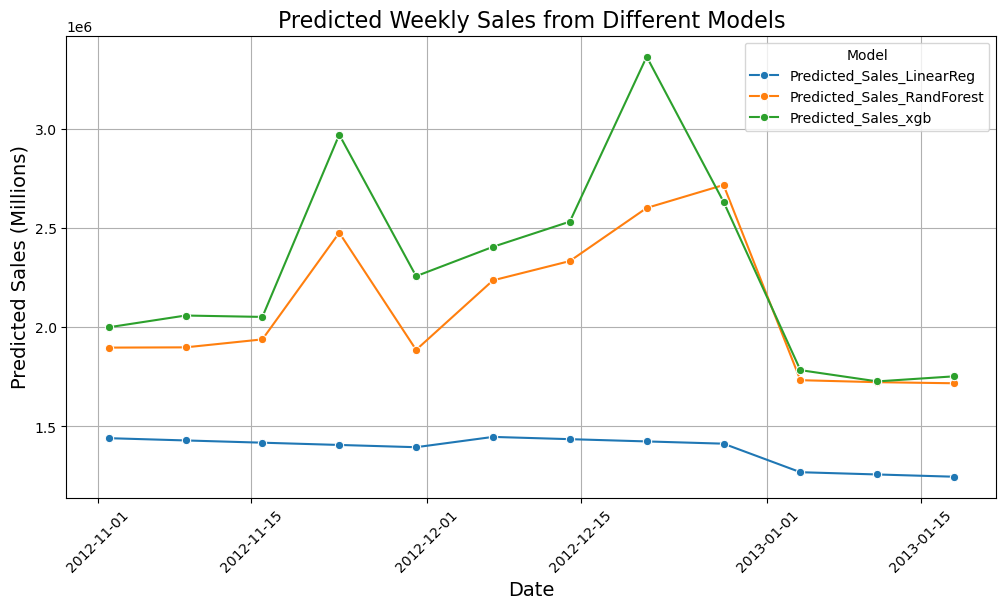

In [31]:
evaluate.future_plot(melted_data)